# CNN Classifier for the face mask detection task

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import torch.nn.functional as F

# Data Loading

In [58]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((120,120)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'test': transforms.Compose([
        transforms.Resize(120),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

In [3]:
image_datasets = {x: datasets.ImageFolder(os.path.join('./Dataset', x), data_transforms[x])
                  for x in ['train', 'test']}

In [4]:
data_loaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True)
                for x in ['train', 'test']}

In [5]:
data_sizes = {x : len(image_datasets[x]) for x in ['train', 'test']}

In [30]:
data_sizes['train']

3929

In [133]:
data = data_loaders['test']

In [166]:
it = iter(data)
d = it.next()
d

[tensor([[[[ 1.6863,  1.6706,  1.6706,  ...,  1.6392,  1.6392,  1.6235],
           [ 1.6863,  1.6706,  1.6706,  ...,  1.6549,  1.6549,  1.6392],
           [ 1.7020,  1.6863,  1.6706,  ...,  1.6706,  1.6706,  1.6549],
           ...,
           [-1.0118, -0.8706, -0.7294,  ...,  1.2941,  1.3098,  1.3255],
           [-0.9804, -0.8549, -0.7137,  ...,  1.3412,  1.3412,  1.3255],
           [-0.9647, -0.8706, -0.7451,  ...,  1.4039,  1.4039,  1.3882]],
 
          [[ 1.6863,  1.6706,  1.6706,  ...,  1.6392,  1.6392,  1.6235],
           [ 1.6863,  1.6706,  1.6706,  ...,  1.6549,  1.6549,  1.6392],
           [ 1.7020,  1.6863,  1.6706,  ...,  1.6549,  1.6549,  1.6392],
           ...,
           [-1.5608, -1.4196, -1.2941,  ...,  1.3255,  1.3412,  1.3569],
           [-1.5451, -1.4353, -1.3255,  ...,  1.3725,  1.3725,  1.3569],
           [-1.5294, -1.4510, -1.3569,  ...,  1.4353,  1.4353,  1.4196]],
 
          [[ 1.7176,  1.7020,  1.7020,  ...,  1.6706,  1.6706,  1.6549],
           [ 

In [135]:
class_names =image_datasets['train'].classes

### Showing a sample from the training data

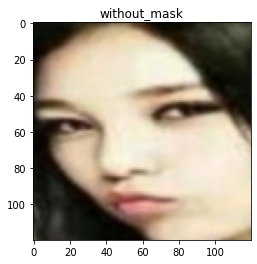

In [136]:
def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()


# Get a batch of training data
inputs, classes = next(iter(data_loaders['train']))

# Make a grid from batch
out = inputs[0]

imshow(out, class_names[classes[0]])

#### Setting up the CNN model

In [11]:
class maskOnNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 100, 3)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(100, 100, 3)
        self.fc1 = nn.Linear(100*28*28, 50)
        self.fc2 = nn.Linear(50, 2)
        self.dropout = nn.Dropout(p=0.5)
    
    def forward(self, x):

        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 100*28*28)
        x = F.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

In [24]:
from tqdm import tqdm

In [12]:
inputs.shape

torch.Size([4, 3, 120, 120])

In [13]:
model = maskOnNet()
out = model(inputs)
print(out.shape)

torch.Size([4, 2])


### Setting up the training loop

In [25]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(data_loaders[phase]):

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / data_sizes[phase]
            epoch_acc = running_corrects.double() / data_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    print('Training complete')
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [26]:
model = maskOnNet()

In [27]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.001)

In [28]:
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [29]:
model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=10)

  0%|          | 0/983 [00:00<?, ?it/s]

Epoch 0/9
----------


 14%|█▍        | 140/983 [01:12<08:40,  1.62it/s]c:\users\chafik\appdata\local\programs\python\python39\lib\site-packages\PIL\Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
  0%|          | 0/234 [00:00<?, ?it/s]

train Loss: 0.3011 Acc: 0.8773


  0%|          | 0/983 [00:00<?, ?it/s]

test Loss: 0.2805 Acc: 0.8963

Epoch 1/9
----------


  0%|          | 1/234 [00:00<00:39,  5.95it/s]

train Loss: 0.1948 Acc: 0.9323


  0%|          | 0/983 [00:00<?, ?it/s]

test Loss: 0.2695 Acc: 0.8952

Epoch 2/9
----------


  0%|          | 1/234 [00:00<00:45,  5.10it/s]

train Loss: 0.1724 Acc: 0.9389


  0%|          | 0/983 [00:00<?, ?it/s]

test Loss: 0.2799 Acc: 0.8930

Epoch 3/9
----------


  0%|          | 1/234 [00:00<00:30,  7.62it/s]

train Loss: 0.1576 Acc: 0.9466


  0%|          | 0/983 [00:00<?, ?it/s]

test Loss: 0.2487 Acc: 0.9059

Epoch 4/9
----------


  0%|          | 0/234 [00:00<?, ?it/s]

train Loss: 0.1447 Acc: 0.9499


  0%|          | 0/983 [00:00<?, ?it/s]

test Loss: 0.2504 Acc: 0.9080

Epoch 5/9
----------


  0%|          | 0/234 [00:00<?, ?it/s]

train Loss: 0.1349 Acc: 0.9501


  0%|          | 0/983 [00:00<?, ?it/s]

test Loss: 0.2426 Acc: 0.9144

Epoch 6/9
----------


  0%|          | 1/234 [00:00<00:36,  6.43it/s]

train Loss: 0.1259 Acc: 0.9590


  0%|          | 0/983 [00:00<?, ?it/s]

test Loss: 0.2336 Acc: 0.9123

Epoch 7/9
----------


  0%|          | 1/234 [00:00<00:40,  5.78it/s]

train Loss: 0.1082 Acc: 0.9636


  0%|          | 0/983 [00:00<?, ?it/s]

test Loss: 0.2307 Acc: 0.9123

Epoch 8/9
----------


  0%|          | 0/234 [00:00<?, ?it/s]

train Loss: 0.1057 Acc: 0.9641


  0%|          | 0/983 [00:00<?, ?it/s]

test Loss: 0.2339 Acc: 0.9112

Epoch 9/9
----------


  0%|          | 1/234 [00:00<00:41,  5.68it/s]

train Loss: 0.1040 Acc: 0.9644


100%|██████████| 234/234 [00:40<00:00,  5.72it/s]


test Loss: 0.2324 Acc: 0.9155

Training complete
Best val Acc: 0.915508


#### Verification for one image

In [167]:
example = d[0][2]
exlab = d[1][2]
exclass = class_names[exlab]

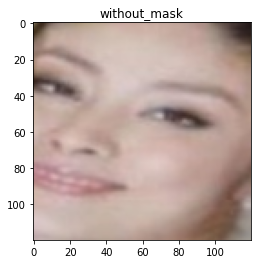

In [168]:
imshow(example, exclass)

In [169]:
out = model(example.view(1,3,120,120))
print(out)

tensor([[-1.5040,  1.1656]], grad_fn=<AddmmBackward>)


In [170]:
_, pred = torch.max(out, 1)

In [171]:
pred

tensor([1])

In [172]:
class_names[pred]

'without_mask'

In [173]:
torch.save(model.state_dict(), './LbesLmask.pth')

In [174]:
import cv2

In [229]:
image_test = cv2.imread('Person.jpg')[:,:,::-1]

In [231]:

trans = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((120, 120)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
    ])

In [232]:
image_test = trans(image_test)

In [158]:
loaded_mod = maskOnNet()
loaded_mod.load_state_dict(torch.load('LbesLmask.pth'))

<All keys matched successfully>

In [205]:
image_test.shape

torch.Size([3, 120, 120])

In [206]:
cl = loaded_mod(image_test.view(1,3,120,120))

In [207]:
cl

tensor([[-0.6459,  0.5393]], grad_fn=<AddmmBackward>)

In [208]:
_, pred = torch.max(cl, 1)

In [209]:
pred

tensor([1])

In [210]:
class_names[pred]

'without_mask'